In [ ]:
# GENYZ TEAM
# Aleta Edna Jessalyn 
# Angelina Wahyuni 
# Keisya Andretta
# Infall Syafalni

# reusing the nmos and pmos primitives from gLayout

In [10]:
import os
import subprocess

# Run a shell, source .bashrc, then printenv
cmd = 'bash -c "source ~/.bashrc && printenv"'
result = subprocess.run(cmd, shell=True, text=True, capture_output=True)
env_vars = {}
for line in result.stdout.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        env_vars[key] = value

# Now, update os.environ with these

os.environ.update(env_vars)

import gdstk
import svgutils.transform as sg
import IPython.display
from IPython.display import clear_output
import ipywidgets as widgets

# Redirect all outputs here
hide = widgets.Output()

def display_gds(gds_file,path,scale = 3):
  
  # Generate an SVG image
  top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
  top_level_cell.write_svg(os.path.join(path,'out.svg'))
    
  # Scale the image for displaying
  fig = sg.fromfile(os.path.join(path,'out.svg'))
  fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
  fig.save(os.path.join(path,'out.svg'))

  # Display the image
  IPython.display.display(IPython.display.SVG(os.path.join(path,'out.svg')))
  os.remove(os.path.join(path,'cs.gds'))

def display_component(component,path,scale = 3):
  # Save to a GDS file
  with hide:
    component.write_gds(os.path.join(path,'cs.gds'))
  display_gds(os.path.join(path,'cs.gds'),path,scale)

from glayout import MappedPDK, sky130 , gf180
#from gdsfactory.cell import cell
from gdsfactory import Component
from gdsfactory.components import text_freetype, rectangle
from glayout import nmos, pmos
from glayout import via_stack, via_array
from glayout import rename_ports_by_orientation
from glayout import tapring
from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route
from glayout.primitives.mimcap import mimcap
import sys
from pathlib import Path
sys.path.append(os.path.abspath("../../CSWITCHv2"))

from my_CSWITCH import cswitch, add_cswitch_labels

2025-09-17 16:26:08.886 | WARNING  | gdsfactory.klive:show:48 - Could not connect to klive server. Is klayout open and klive plugin installed?


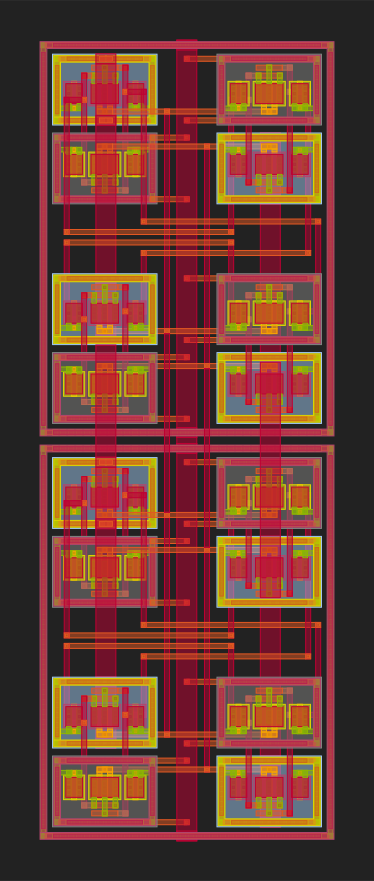

In [11]:
chopper_switch_b = {
    "pdk": gf180,
    "placement" : "vertical",  
    "width": (2,2),
    "length": (0.5,0.5),
    "fingers": (2,2),
    "multipliers": (1,1),
    "dummy_1": (True,True),
    "dummy_2": (True,True),
    "tie_layers1": ("met2","met1"),
    "tie_layers2": ("met2","met1"),
    "sd_rmult":1,
}

top_level = Component(name="chopper_switch_b")
pdk = chopper_switch_b["pdk"]
pdk.activate()

CS1 = cswitch(
    pdk,
    width=chopper_switch_b["width"],
    length=chopper_switch_b["length"],
    fingers=chopper_switch_b["fingers"],
    multipliers=chopper_switch_b["multipliers"],
    dummy_1=chopper_switch_b["dummy_1"],
    dummy_2=chopper_switch_b["dummy_2"],
    tie_layers1=chopper_switch_b["tie_layers1"],
    tie_layers2=chopper_switch_b["tie_layers2"],
    sd_rmult=chopper_switch_b["sd_rmult"],
)

CS1_ref = top_level << CS1
CS2_ref = top_level << CS1

CS1_ref.name = "CS1"
CS2_ref.name = "CS2"

ref_dimensions = evaluate_bbox(CS1_ref)
CS2_ref.movey(- ref_dimensions[1] - pdk.util_max_metal_seperation()*2) 

# VSS Routing CSB
top_level << straight_route(pdk, CS2_ref.ports["VSS_TOP_top_met_N"], CS1_ref.ports["VSS_BOTTOM_top_met_S"])

# Left VDD Routing CSB
top_level << straight_route(pdk, CS2_ref.ports["VDD_TOPL_top_met_N"], CS1_ref.ports["VDD_BOTTOML_top_met_S"])

# Right VDD Routing CSB
top_level << straight_route(pdk, CS2_ref.ports["VDD_TOPR_top_met_N"], CS1_ref.ports["VDD_BOTTOMR_top_met_S"])

# CLK Routing 
top_level << straight_route(pdk, CS2_ref.ports["CLK_TOP_top_met_N"], CS1_ref.ports["CLK_BOTTOM_top_met_S"])

# CLK_inv Routing
top_level << straight_route(pdk, CS2_ref.ports["CLKINV_TOP_top_met_N"], CS1_ref.ports["CLKINV_BOTTOM_top_met_S"])

top_level.show()
display_component(top_level, scale=1, path="../")

2025-09-17 16:26:10.299 | WARNING  | gdsfactory.klive:show:48 - Could not connect to klive server. Is klayout open and klive plugin installed?


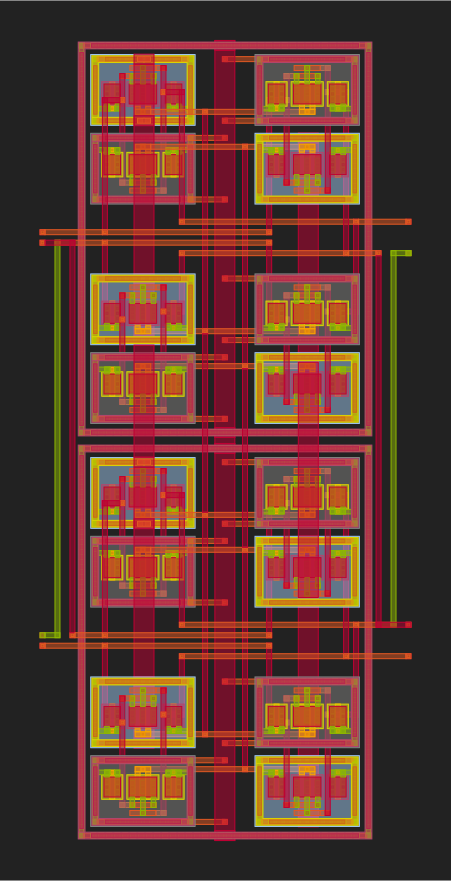

In [12]:
# Input
viam2m3 = via_stack(pdk, "met2", "met3", centered=True)
viam1m2 = via_stack(pdk, "met1", "met2", centered=True)
vinp1_via = top_level << viam2m3
vinp2_via = top_level << viam1m2
vinp3_via = top_level << viam1m2 # Helper for vinp2
vinn1_via = top_level << viam2m3
vinn2_via = top_level << viam2m3
vinn3_via = top_level << viam2m3 # Helper for vinn1

vinp1_via.move(CS1_ref.ports["INP_bottom_met_W"].center).movex(-6)
vinp2_via.move(CS2_ref.ports["INP_bottom_met_W"].center).movex(-6)
vinp3_via.move(CS1_ref.ports["INN_bottom_met_W"].center).movex(-4.5)
vinn1_via.move(CS1_ref.ports["INN_bottom_met_W"].center).movex(-6)
vinn2_via.move(CS2_ref.ports["INN_bottom_met_W"].center).movex(-6)
vinn3_via.move(CS2_ref.ports["INP_bottom_met_W"].center).movex(-3)

top_level << straight_route(pdk, CS1_ref.ports["INP_bottom_met_W"], vinp1_via.ports["bottom_met_E"]) 
top_level << straight_route(pdk, CS1_ref.ports["INN_bottom_met_W"], vinp3_via.ports["top_met_E"]) 
top_level << L_route(pdk, vinp3_via.ports["bottom_met_S"], vinp2_via.ports["bottom_met_E"])
top_level << L_route(pdk, vinn1_via.ports["top_met_E"], vinn3_via.ports["top_met_N"])
top_level << straight_route(pdk, vinn3_via.ports["bottom_met_E"], CS2_ref.ports["INP_bottom_met_W"])
top_level << straight_route(pdk, vinn2_via.ports["bottom_met_E"], CS2_ref.ports["INN_bottom_met_W"]) 

#Output
voutp1_via = top_level << viam2m3
voutn1_via = top_level << viam1m2
voutp2_via = top_level << viam2m3
voutn2_via = top_level << viam2m3
voutn1h_via = top_level << viam1m2
voutp2h_via = top_level << viam2m3

voutp1_via.move(CS1_ref.ports["OUTP_bottom_met_E"].center).movex(5)
voutn1_via.move(CS1_ref.ports["OUTN_bottom_met_E"].center).movex(6)
voutp2_via.move(CS2_ref.ports["OUTP_bottom_met_E"].center).movex(5)
voutn2_via.move(CS2_ref.ports["OUTN_bottom_met_E"].center).movex(6)
voutn1h_via.move(CS2_ref.ports["OUTP_bottom_met_E"].center).movex(3.5)
voutp2h_via.move(CS1_ref.ports["OUTN_bottom_met_E"].center).movex(3)

top_level << straight_route(pdk, CS1_ref.ports["OUTP_bottom_met_E"], voutp1_via.ports["bottom_met_W"])
top_level << straight_route(pdk, CS2_ref.ports["OUTN_bottom_met_E"], voutn2_via.ports["bottom_met_W"])
top_level << straight_route(pdk, CS1_ref.ports["OUTN_bottom_met_E"], voutp2h_via.ports["bottom_met_W"])
top_level << straight_route(pdk, CS2_ref.ports["OUTP_bottom_met_E"], voutn1h_via.ports["top_met_W"])
top_level << L_route(pdk, voutn1_via.ports["bottom_met_E"], voutn1h_via.ports["bottom_met_S"])
top_level << L_route(pdk, voutp2_via.ports["top_met_E"], voutp2h_via.ports["top_met_S"])


top_level.show()
display_component(top_level, scale = 1,path="../")

2025-09-17 16:26:11.497 | WARNING  | gdsfactory.klive:show:48 - Could not connect to klive server. Is klayout open and klive plugin installed?


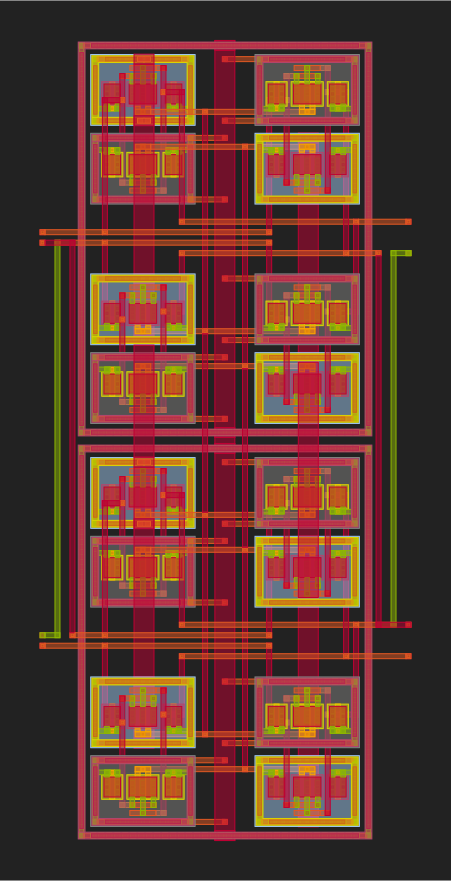

In [13]:
top_level.add_ports(CS1_ref.get_ports_list(), prefix="CS1_")
top_level.add_ports(CS2_ref.get_ports_list(), prefix="CS2_")

top_level.add_ports(vinp1_via.get_ports_list(), prefix="VINP1_")
top_level.add_ports(vinn1_via.get_ports_list(), prefix="VINN1_")
top_level.add_ports(vinp2_via.get_ports_list(), prefix="VINP2_")
top_level.add_ports(vinn2_via.get_ports_list(), prefix="VINN2_")

top_level.add_ports(voutp1_via.get_ports_list(), prefix="VOUTP1_")
top_level.add_ports(voutn1_via.get_ports_list(), prefix="VOUTN1_")
top_level.add_ports(voutp2_via.get_ports_list(), prefix="VOUTP2_")
top_level.add_ports(voutn2_via.get_ports_list(), prefix="VOUTN2_")

component = component_snap_to_grid(rename_ports_by_orientation(top_level))
component.show()
display_component(top_level, scale =1,path="../")

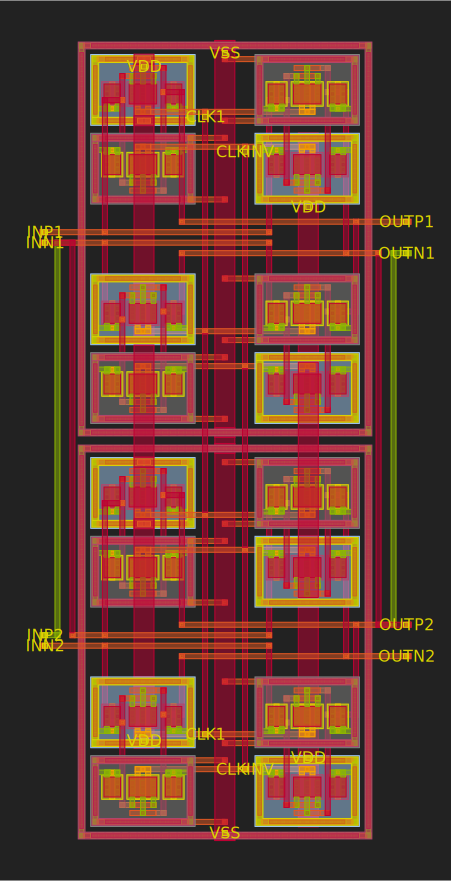

In [14]:
psize=(0.5,0.5)
# list that will contain all port/comp info
move_info = list()
# create labels and append to info list

inputp1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
inputp1label.add_label(text="INP1",layer=pdk.get_glayer("met3_pin"))
move_info.append((inputp1label,component.ports["VINP1_top_met_E"], None))
inputp2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
inputp2label.add_label(text="INP2",layer=pdk.get_glayer("met3_pin"))
move_info.append((inputp2label,component.ports["VINP2_top_met_E"], None))

inputn1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
inputn1label.add_label(text="INN1",layer=pdk.get_glayer("met3_pin"))
move_info.append((inputn1label,component.ports["VINN1_top_met_E"], None))
inputn2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
inputn2label.add_label(text="INN2",layer=pdk.get_glayer("met3_pin"))
move_info.append((inputn2label,component.ports["VINN2_top_met_E"], None))

outputp1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
outputp1label.add_label(text="OUTP1",layer=pdk.get_glayer("met3_pin"))
move_info.append((outputp1label,component.ports["VOUTP1_top_met_W"],None))
outputp2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
outputp2label.add_label(text="OUTP2",layer=pdk.get_glayer("met3_pin"))
move_info.append((outputp2label,component.ports["VOUTP2_top_met_W"],None))

outputn1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
outputn1label.add_label(text="OUTN1",layer=pdk.get_glayer("met3_pin"))
move_info.append((outputn1label,component.ports["VOUTN1_top_met_W"],None))
outputn2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
outputn2label.add_label(text="OUTN2",layer=pdk.get_glayer("met3_pin"))
move_info.append((outputn2label,component.ports["VOUTN2_top_met_W"],None))

vsstop1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
vsstop1label.add_label(text="VSS",layer=pdk.get_glayer("met3_label"))
move_info.append((vsstop1label,component.ports["CS1_VSS_TOP_top_met_S"],None))
vssbottom2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
vssbottom2label.add_label(text="VSS",layer=pdk.get_glayer("met3_label"))
move_info.append((vssbottom2label,component.ports["CS2_VSS_BOTTOM_top_met_N"],None))

vddtopllabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
vddtopllabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
move_info.append((vddtopllabel,component.ports["CS1_VDD_TOPL_top_met_S"],None))
vddtoprlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
vddtoprlabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
move_info.append((vddtoprlabel,component.ports["CS1_VDD_TOPR_top_met_S"],None))

vddbottomllabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
vddbottomllabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
move_info.append((vddbottomllabel,component.ports["CS2_VDD_BOTTOML_top_met_N"],None))
vddbottomrlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
vddbottomrlabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
move_info.append((vddbottomrlabel,component.ports["CS2_VDD_BOTTOMR_top_met_N"],None))

clktoplabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
clktoplabel.add_label(text="CLK1",layer=pdk.get_glayer("met3_pin"))
move_info.append((clktoplabel,component.ports["CS1_CLK_TOP_top_met_S"], None))
clkbottomlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
clkbottomlabel.add_label(text="CLK1",layer=pdk.get_glayer("met3_pin"))
move_info.append((clkbottomlabel,component.ports["CS2_CLK_BOTTOM_top_met_N"], None))

clkinvtoplabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
clkinvtoplabel.add_label(text="CLKINV",layer=pdk.get_glayer("met3_pin"))
move_info.append((clkinvtoplabel,component.ports["CS1_CLKINV_TOP_top_met_S"], None))
clkinvbottomlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
clkinvbottomlabel.add_label(text="CLKINV",layer=pdk.get_glayer("met3_pin"))
move_info.append((clkinvbottomlabel,component.ports["CS2_CLKINV_BOTTOM_top_met_N"], None))

for comp, prt, alignment in move_info:
        alignment = ('c','b') if alignment is None else alignment
        compref = align_comp_to_port(comp, prt, alignment=alignment)
        top_level.add(compref)

display_component(top_level, scale =1,path="../")

In [15]:
comps = top_level.flatten()
comps.name="cswitchb"
drc_result = gf180.drc_magic(comps, comps.name)

2025-09-17 16:26:12.463 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to '/tmp/tmpblp9z6j1/cswitchb$1.gds'


using default pdk_root
Defaulting to stale magic_commands.tcl

Magic 8.3 revision 528 - Compiled on Wed Jun 18 09:45:25 PM CEST 2025.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology gf180mcuD ...
10 Magic internal units = 1 Lambda
Input style import: scaleFactor=10, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    obsactive mvobsactive filldiff fillpoly m1hole obsm1 fillm1 obsv1 m2hole obsm2 fillm2 obsv2 m3hole obsm3 fillm3 m4hole obsm4 fillm4 m5hole obsm5 fillm5 glass fillblock lvstext obscomment 
Scaled tech values by 10 / 1 to match internal grid scaling
Loading gf180mcuD Device Generator Menu ...
Loading "/tmp/tmpblp9z6j1/magic_commands.tcl" from command line.
Library written using GDS-II Release 6.0
Library name: library
Reading "cswitchb$1".
[INFO]: Loading cswitchb$1

Loading DRC CIF style.
No e

In [16]:
inv_code_string = """
from glayout import MappedPDK, sky130 , gf180
#from gdsfactory.cell import cell
from gdsfactory import Component
from gdsfactory.components import text_freetype, rectangle
from glayout import nmos, pmos
from glayout import via_stack, via_array
from glayout import rename_ports_by_orientation
from glayout import tapring
from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route

import os
import subprocess

# Run a shell, source .bashrc, then printenv
cmd = 'bash -c "source ~/.bashrc && printenv"'
result = subprocess.run(cmd, shell=True, text=True, capture_output=True)
env_vars = {}
for line in result.stdout.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        env_vars[key] = value

# Now, update os.environ with these
os.environ.update(env_vars)

import sys
from pathlib import Path
sys.path.append(os.path.abspath("../../CSWITCHv2"))

from my_CSWITCH import cswitch

def add_cswitchb_labels(
    cswitchb_in: Component,
    pdk: MappedPDK,
    ) -> Component:
    
    cswitchb_in.unlock()

    psize=(0.5,0.5)
    # list that will contain all port/comp info
    move_info = list()
    # create labels and append to info list

    # INPUT
    inputp1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    inputp1label.add_label(text="INP1",layer=pdk.get_glayer("met3_pin"))
    move_info.append((inputp1label,cswitchb_in.ports["VINP1_top_met_E"], None))
    inputp2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    inputp2label.add_label(text="INP2",layer=pdk.get_glayer("met3_pin"))
    move_info.append((inputp2label,cswitchb_in.ports["VINP2_top_met_E"], None))

    inputn1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    inputn1label.add_label(text="INN1",layer=pdk.get_glayer("met3_pin"))
    move_info.append((inputn1label,cswitchb_in.ports["VINN1_top_met_E"], None))
    inputn2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    inputn2label.add_label(text="INN2",layer=pdk.get_glayer("met3_pin"))
    move_info.append((inputn2label,cswitchb_in.ports["VINN2_top_met_E"], None))

    outputp1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    outputp1label.add_label(text="OUTP1",layer=pdk.get_glayer("met3_pin"))
    move_info.append((outputp1label,cswitchb_in.ports["VOUTP1_top_met_W"],None))
    outputp2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    outputp2label.add_label(text="OUTP2",layer=pdk.get_glayer("met3_pin"))
    move_info.append((outputp2label,cswitchb_in.ports["VOUTP2_top_met_W"],None))

    outputn1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    outputn1label.add_label(text="OUTN1",layer=pdk.get_glayer("met3_pin"))
    move_info.append((outputn1label,cswitchb_in.ports["VOUTN1_top_met_W"],None))
    outputn2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    outputn2label.add_label(text="OUTN2",layer=pdk.get_glayer("met3_pin"))
    move_info.append((outputn2label,cswitchb_in.ports["VOUTN2_top_met_W"],None))

    vsstop1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    vsstop1label.add_label(text="VSS",layer=pdk.get_glayer("met3_label"))
    move_info.append((vsstop1label,cswitchb_in.ports["CS1_VSS_TOP_top_met_S"],None))
    vssbottom2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    vssbottom2label.add_label(text="VSS",layer=pdk.get_glayer("met3_label"))
    move_info.append((vssbottom2label,cswitchb_in.ports["CS2_VSS_BOTTOM_top_met_N"],None))

    vddtopllabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    vddtopllabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
    move_info.append((vddtopl1label,cswitchb_in.ports["CS1_VDD_TOPL_top_met_S"],None))
    vddtoprlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    vddtoprlabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
    move_info.append((vddtopr1label,cswitchb_in.ports["CS1_VDD_TOPR_top_met_S"],None))

    vddbottomllabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    vddbottomllabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
    move_info.append((vddbottoml1label,cswitchb_in.ports["CS2_VDD_BOTTOML_top_met_N"],None))
    vddbottomrlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    vddbottomrlabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
    move_info.append((vddbottomr1label,cswitchb_in.ports["CS2_VDD_BOTTOMR_top_met_N"],None))

    clktoplabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    clktoplabel.add_label(text="CLK1",layer=pdk.get_glayer("met3_pin"))
    move_info.append((clktop1label,cswitchb_in.ports["CS1_CLK_TOP_top_met_S"], None))
    clkbottomlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    clkbottomlabel.add_label(text="CLK1",layer=pdk.get_glayer("met3_pin"))
    move_info.append((clkbottom1label,cswitchb_in.ports["CS2_CLK_BOTTOM_top_met_N"], None))

    clkinvtoplabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    clkinvtoplabel.add_label(text="CLKINV",layer=pdk.get_glayer("met3_pin"))
    move_info.append((clkinvtop1label,cswitchb_in.ports["CS1_CLKINV_TOP_top_met_S"], None))
    clkinvbottomlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    clkinvbottomlabel.add_label(text="CLKINV",layer=pdk.get_glayer("met3_pin"))
    move_info.append((clkinvbottom2label,cswitchb_in.ports["CS2_CLKINV_BOTTOM_top_met_N"], None))

    for comp, prt, alignment in move_info:
            alignment = ('c','b') if alignment is None else alignment
            compref = align_comp_to_port(comp, prt, alignment=alignment)
            cswitchb_in.add(compref)
    
    return cswitchb_in.flatten()

def cswitchb(
        pdk: MappedPDK,
        width: tuple[float,float] = (2,2),
        length: tuple[float,float] = (0.5,0.5),
        fingers: tuple[int,int] = (2,2),
        multipliers: tuple[int,int] = (1,1),
        dummy_1: tuple[bool,bool] = (True,True),
        dummy_2: tuple[bool,bool] = (True,True),
        tie_layers1: tuple[str,str] = ("met2","met1"),
        tie_layers2: tuple[str,str] = ("met2","met1"),
        sd_rmult: int=1,
        **kwargs
        ) -> Component:

    pdk.activate()
    
    #top level component
    top_level = Component(name="cswitchb")

    CS1 = cswitch(pdk,(width[0],width[1]),(length[0],length[1]),(fingers[0],fingers[1]),(multipliers[0],multipliers[1]))

    CS1_ref = top_level << CS1
    CS2_ref = top_level << CS1

    CS1_ref.name = "CS1"
    CS2_ref.name = "CS2"

    ref_dimensions = evaluate_bbox(CS1_ref)
    CS2_ref.movey( - ref_dimensions[1] - pdk.util_max_metal_seperation()*2) 

    viam2m3 = via_stack(pdk, "met2", "met3", centered=True) #met2 is the bottom layer. met3 is the top layer.
    
    #input routes
    viam2m3 = via_stack(pdk, "met2", "met3", centered=True)
    viam1m2 = via_stack(pdk, "met1", "met2", centered=True)
    vinp1_via = top_level << viam2m3
    vinp2_via = top_level << viam1m2
    vinp3_via = top_level << viam1m2 # Helper for vinp2
    vinn1_via = top_level << viam2m3
    vinn2_via = top_level << viam2m3
    vinn3_via = top_level << viam2m3 # Helper for vinn1

    vinp1_via.move(CS1_ref.ports["INP_bottom_met_W"].center).movex(-6)
    vinp2_via.move(CS2_ref.ports["INP_bottom_met_W"].center).movex(-6)
    vinp3_via.move(CS1_ref.ports["INN_bottom_met_W"].center).movex(-4.5)
    vinn1_via.move(CS1_ref.ports["INN_bottom_met_W"].center).movex(-6)
    vinn2_via.move(CS2_ref.ports["INN_bottom_met_W"].center).movex(-6)
    vinn3_via.move(CS2_ref.ports["INP_bottom_met_W"].center).movex(-3)

    top_level << straight_route(pdk, CS1_ref.ports["INP_bottom_met_W"], vinp1_via.ports["bottom_met_E"]) 
    top_level << straight_route(pdk, CS1_ref.ports["INN_bottom_met_W"], vinp3_via.ports["top_met_E"]) 
    top_level << L_route(pdk, vinp3_via.ports["bottom_met_S"], vinp2_via.ports["bottom_met_E"])
    top_level << L_route(pdk, vinn1_via.ports["top_met_E"], vinn3_via.ports["top_met_N"])
    top_level << straight_route(pdk, vinn3_via.ports["bottom_met_E"], CS2_ref.ports["INP_bottom_met_W"])
    top_level << straight_route(pdk, vinn2_via.ports["bottom_met_E"], CS2_ref.ports["INN_bottom_met_W"])

    #output routes
    voutp1_via = top_level << viam2m3
    voutn1_via = top_level << viam1m2
    voutp2_via = top_level << viam2m3
    voutn2_via = top_level << viam2m3
    voutn1h_via = top_level << viam1m2
    voutp2h_via = top_level << viam2m3

    voutp1_via.move(CS1_ref.ports["OUTP_bottom_met_E"].center).movex(5)
    voutn1_via.move(CS1_ref.ports["OUTN_bottom_met_E"].center).movex(6)
    voutp2_via.move(CS2_ref.ports["OUTP_bottom_met_E"].center).movex(5)
    voutn2_via.move(CS2_ref.ports["OUTN_bottom_met_E"].center).movex(6)
    voutn1h_via.move(CS2_ref.ports["OUTP_bottom_met_E"].center).movex(3.5)
    voutp2h_via.move(CS1_ref.ports["OUTN_bottom_met_E"].center).movex(3)

    top_level << straight_route(pdk, CS1_ref.ports["OUTP_bottom_met_E"], voutp1_via.ports["bottom_met_W"])
    top_level << straight_route(pdk, CS2_ref.ports["OUTN_bottom_met_E"], voutn2_via.ports["bottom_met_W"])
    top_level << straight_route(pdk, CS1_ref.ports["OUTN_bottom_met_E"], voutp2h_via.ports["bottom_met_W"])
    top_level << straight_route(pdk, CS2_ref.ports["OUTP_bottom_met_E"], voutn1h_via.ports["top_met_W"])
    top_level << L_route(pdk, voutn1_via.ports["bottom_met_E"], voutn1h_via.ports["bottom_met_S"])
    top_level << L_route(pdk, voutp2_via.ports["top_met_E"], voutp2h_via.ports["top_met_S"])

    # VSS Routing CSB
    top_level << straight_route(pdk, CS2_ref.ports["VSS_TOP_top_met_N"], CS1_ref.ports["VSS_BOTTOM_top_met_S"])

    # Left VDD Routing CSB
    top_level << straight_route(pdk, CS2_ref.ports["VDD_TOPL_top_met_N"], CS1_ref.ports["VDD_BOTTOML_top_met_S"])

    # Right VDD Routing CSB
    top_level << straight_route(pdk, CS2_ref.ports["VDD_TOPR_top_met_N"], CS1_ref.ports["VDD_BOTTOMR_top_met_S"])

    # CLK Routing 
    top_level << straight_route(pdk, CS2_ref.ports["CLK_TOP_top_met_N"], CS1_ref.ports["CLK_BOTTOM_top_met_S"])

    # CLK_inv Routing
    top_level << straight_route(pdk, CS2_ref.ports["CLKINV_TOP_top_met_N"], CS1_ref.ports["CLKINV_BOTTOM_top_met_S"])

    top_level.add_ports(CS1_ref.get_ports_list(), prefix="CS1_")
    top_level.add_ports(CS2_ref.get_ports_list(), prefix="CS2_")
    
    top_level.add_ports(vinp1_via.get_ports_list(), prefix="VINP1_")
    top_level.add_ports(vinn1_via.get_ports_list(), prefix="VINN1_")
    top_level.add_ports(vinp2_via.get_ports_list(), prefix="VINP2_")
    top_level.add_ports(vinn2_via.get_ports_list(), prefix="VINN2_")
    
    top_level.add_ports(voutp1_via.get_ports_list(), prefix="VOUTP1_")
    top_level.add_ports(voutn1_via.get_ports_list(), prefix="VOUTN1_")
    top_level.add_ports(voutp2_via.get_ports_list(), prefix="VOUTP2_")
    top_level.add_ports(voutn2_via.get_ports_list(), prefix="VOUTN2_")

    return component_snap_to_grid(rename_ports_by_orientation(top_level))

if __name__ == "__main__":
\tcomp = cswitchb(gf180)\n
\t# comp.pprint_ports()\n
\tcomp = add_cswitchb_labels(comp, gf180)\n
\tcomp.name = "CSWITCHB"\n
\tcomp.write_gds('out_CSWITCHB.gds')\n
\tcomp.show()\n
\tprint("...Running DRC...")\n
\tdrc_result = gf180.drc_magic(comp, "CSWITCHB")\n
\tdrc_result = gf180.drc(comp)\n
"""

inv_init_string = """
###Glayout CSWITCH Cell.


from .my_CSWITCHB import cswitchb,add_cswitchb_labels

__all__ = [
    'cswitchb',
    'add_cswitchb_labels',
] 
"""

directory = "../../CSWITCHBv2/"
os.makedirs(directory, exist_ok=True)

# Save to a .py file
with open(directory + "my_CSWITCHB.py", "w") as file:
    file.write(inv_code_string)

with open(directory + "__init__.py", "w") as file:
    file.write(inv_init_string)

In [10]:
import os
import subprocess

# Run a shell, source .bashrc, then printenv
cmd = 'bash -c "source ~/.bashrc && printenv"'
result = subprocess.run(cmd, shell=True, text=True, capture_output=True)
env_vars = {}
for line in result.stdout.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        env_vars[key] = value

# Now, update os.environ with these

os.environ.update(env_vars)

import gdstk
import svgutils.transform as sg
import IPython.display
from IPython.display import clear_output
import ipywidgets as widgets

# Redirect all outputs here
hide = widgets.Output()

def display_gds(gds_file,path,scale = 3):
  
  # Generate an SVG image
  top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
  top_level_cell.write_svg(os.path.join(path,'out.svg'))
    
  # Scale the image for displaying
  fig = sg.fromfile(os.path.join(path,'out.svg'))
  fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
  fig.save(os.path.join(path,'out.svg'))

  # Display the image
  IPython.display.display(IPython.display.SVG(os.path.join(path,'out.svg')))
  os.remove(os.path.join(path,'cs.gds'))

def display_component(component,path,scale = 3):
  # Save to a GDS file
  with hide:
    component.write_gds(os.path.join(path,'cs.gds'))
  display_gds(os.path.join(path,'cs.gds'),path,scale)

from glayout import MappedPDK, sky130 , gf180
#from gdsfactory.cell import cell
from gdsfactory import Component
from gdsfactory.components import text_freetype, rectangle
from glayout import nmos, pmos
from glayout import via_stack, via_array
from glayout import rename_ports_by_orientation
from glayout import tapring
from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route
from glayout.primitives.mimcap import mimcap
import sys
from pathlib import Path
sys.path.append(os.path.abspath("../../CSWITCHv2"))

from my_CSWITCH import cswitch, add_cswitch_labels

2025-09-17 16:26:08.886 | WARNING  | gdsfactory.klive:show:48 - Could not connect to klive server. Is klayout open and klive plugin installed?


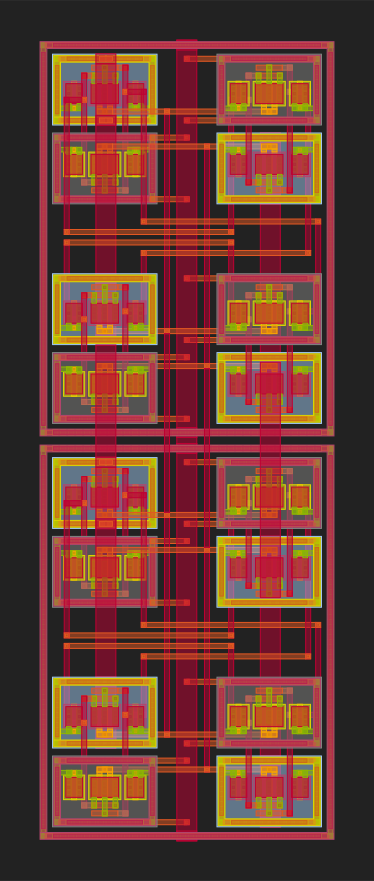

In [11]:
chopper_switch_b = {
    "pdk": gf180,
    "placement" : "vertical",  
    "width": (2,2),
    "length": (0.5,0.5),
    "fingers": (2,2),
    "multipliers": (1,1),
    "dummy_1": (True,True),
    "dummy_2": (True,True),
    "tie_layers1": ("met2","met1"),
    "tie_layers2": ("met2","met1"),
    "sd_rmult":1,
}

top_level = Component(name="chopper_switch_b")
pdk = chopper_switch_b["pdk"]
pdk.activate()

CS1 = cswitch(
    pdk,
    width=chopper_switch_b["width"],
    length=chopper_switch_b["length"],
    fingers=chopper_switch_b["fingers"],
    multipliers=chopper_switch_b["multipliers"],
    dummy_1=chopper_switch_b["dummy_1"],
    dummy_2=chopper_switch_b["dummy_2"],
    tie_layers1=chopper_switch_b["tie_layers1"],
    tie_layers2=chopper_switch_b["tie_layers2"],
    sd_rmult=chopper_switch_b["sd_rmult"],
)

CS1_ref = top_level << CS1
CS2_ref = top_level << CS1

CS1_ref.name = "CS1"
CS2_ref.name = "CS2"

ref_dimensions = evaluate_bbox(CS1_ref)
CS2_ref.movey(- ref_dimensions[1] - pdk.util_max_metal_seperation()*2) 

# VSS Routing CSB
top_level << straight_route(pdk, CS2_ref.ports["VSS_TOP_top_met_N"], CS1_ref.ports["VSS_BOTTOM_top_met_S"])

# Left VDD Routing CSB
top_level << straight_route(pdk, CS2_ref.ports["VDD_TOPL_top_met_N"], CS1_ref.ports["VDD_BOTTOML_top_met_S"])

# Right VDD Routing CSB
top_level << straight_route(pdk, CS2_ref.ports["VDD_TOPR_top_met_N"], CS1_ref.ports["VDD_BOTTOMR_top_met_S"])

# CLK Routing 
top_level << straight_route(pdk, CS2_ref.ports["CLK_TOP_top_met_N"], CS1_ref.ports["CLK_BOTTOM_top_met_S"])

# CLK_inv Routing
top_level << straight_route(pdk, CS2_ref.ports["CLKINV_TOP_top_met_N"], CS1_ref.ports["CLKINV_BOTTOM_top_met_S"])

top_level.show()
display_component(top_level, scale=1, path="../")

2025-09-17 16:26:10.299 | WARNING  | gdsfactory.klive:show:48 - Could not connect to klive server. Is klayout open and klive plugin installed?


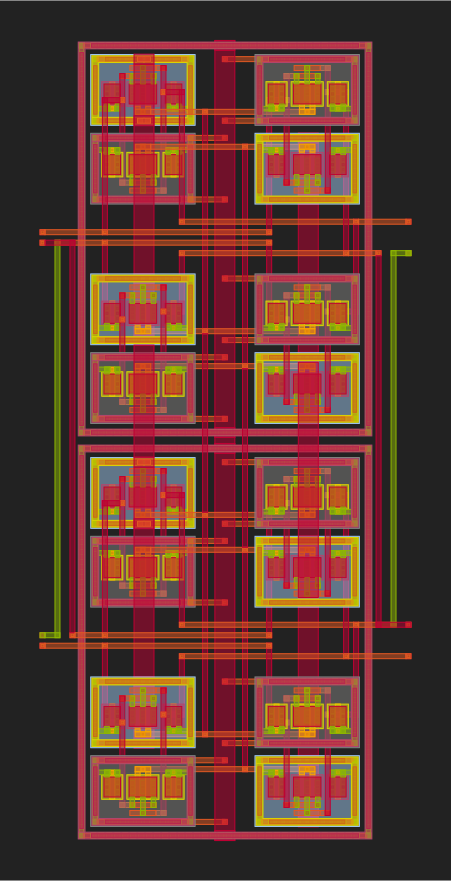

In [12]:
# Input
viam2m3 = via_stack(pdk, "met2", "met3", centered=True)
viam1m2 = via_stack(pdk, "met1", "met2", centered=True)
vinp1_via = top_level << viam2m3
vinp2_via = top_level << viam1m2
vinp3_via = top_level << viam1m2 # Helper for vinp2
vinn1_via = top_level << viam2m3
vinn2_via = top_level << viam2m3
vinn3_via = top_level << viam2m3 # Helper for vinn1

vinp1_via.move(CS1_ref.ports["INP_bottom_met_W"].center).movex(-6)
vinp2_via.move(CS2_ref.ports["INP_bottom_met_W"].center).movex(-6)
vinp3_via.move(CS1_ref.ports["INN_bottom_met_W"].center).movex(-4.5)
vinn1_via.move(CS1_ref.ports["INN_bottom_met_W"].center).movex(-6)
vinn2_via.move(CS2_ref.ports["INN_bottom_met_W"].center).movex(-6)
vinn3_via.move(CS2_ref.ports["INP_bottom_met_W"].center).movex(-3)

top_level << straight_route(pdk, CS1_ref.ports["INP_bottom_met_W"], vinp1_via.ports["bottom_met_E"]) 
top_level << straight_route(pdk, CS1_ref.ports["INN_bottom_met_W"], vinp3_via.ports["top_met_E"]) 
top_level << L_route(pdk, vinp3_via.ports["bottom_met_S"], vinp2_via.ports["bottom_met_E"])
top_level << L_route(pdk, vinn1_via.ports["top_met_E"], vinn3_via.ports["top_met_N"])
top_level << straight_route(pdk, vinn3_via.ports["bottom_met_E"], CS2_ref.ports["INP_bottom_met_W"])
top_level << straight_route(pdk, vinn2_via.ports["bottom_met_E"], CS2_ref.ports["INN_bottom_met_W"]) 

#Output
voutp1_via = top_level << viam2m3
voutn1_via = top_level << viam1m2
voutp2_via = top_level << viam2m3
voutn2_via = top_level << viam2m3
voutn1h_via = top_level << viam1m2
voutp2h_via = top_level << viam2m3

voutp1_via.move(CS1_ref.ports["OUTP_bottom_met_E"].center).movex(5)
voutn1_via.move(CS1_ref.ports["OUTN_bottom_met_E"].center).movex(6)
voutp2_via.move(CS2_ref.ports["OUTP_bottom_met_E"].center).movex(5)
voutn2_via.move(CS2_ref.ports["OUTN_bottom_met_E"].center).movex(6)
voutn1h_via.move(CS2_ref.ports["OUTP_bottom_met_E"].center).movex(3.5)
voutp2h_via.move(CS1_ref.ports["OUTN_bottom_met_E"].center).movex(3)

top_level << straight_route(pdk, CS1_ref.ports["OUTP_bottom_met_E"], voutp1_via.ports["bottom_met_W"])
top_level << straight_route(pdk, CS2_ref.ports["OUTN_bottom_met_E"], voutn2_via.ports["bottom_met_W"])
top_level << straight_route(pdk, CS1_ref.ports["OUTN_bottom_met_E"], voutp2h_via.ports["bottom_met_W"])
top_level << straight_route(pdk, CS2_ref.ports["OUTP_bottom_met_E"], voutn1h_via.ports["top_met_W"])
top_level << L_route(pdk, voutn1_via.ports["bottom_met_E"], voutn1h_via.ports["bottom_met_S"])
top_level << L_route(pdk, voutp2_via.ports["top_met_E"], voutp2h_via.ports["top_met_S"])


top_level.show()
display_component(top_level, scale = 1,path="../")

2025-09-17 16:26:11.497 | WARNING  | gdsfactory.klive:show:48 - Could not connect to klive server. Is klayout open and klive plugin installed?


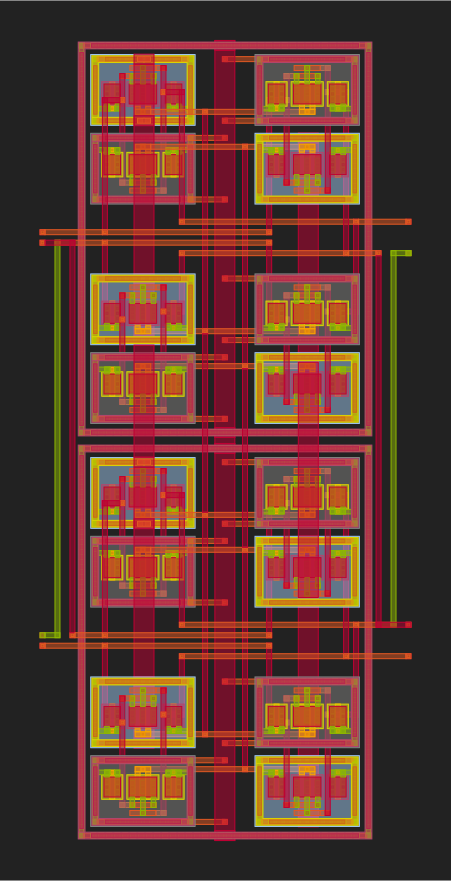

In [13]:
top_level.add_ports(CS1_ref.get_ports_list(), prefix="CS1_")
top_level.add_ports(CS2_ref.get_ports_list(), prefix="CS2_")

top_level.add_ports(vinp1_via.get_ports_list(), prefix="VINP1_")
top_level.add_ports(vinn1_via.get_ports_list(), prefix="VINN1_")
top_level.add_ports(vinp2_via.get_ports_list(), prefix="VINP2_")
top_level.add_ports(vinn2_via.get_ports_list(), prefix="VINN2_")

top_level.add_ports(voutp1_via.get_ports_list(), prefix="VOUTP1_")
top_level.add_ports(voutn1_via.get_ports_list(), prefix="VOUTN1_")
top_level.add_ports(voutp2_via.get_ports_list(), prefix="VOUTP2_")
top_level.add_ports(voutn2_via.get_ports_list(), prefix="VOUTN2_")

component = component_snap_to_grid(rename_ports_by_orientation(top_level))
component.show()
display_component(top_level, scale =1,path="../")

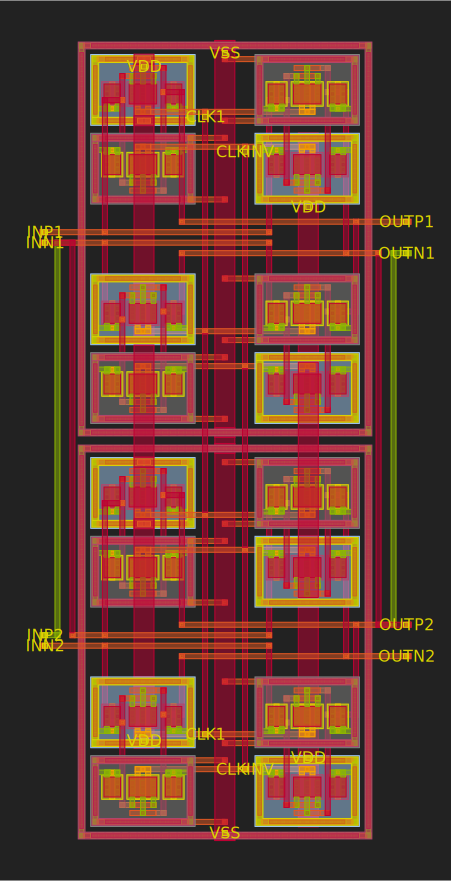

In [14]:
psize=(0.5,0.5)
# list that will contain all port/comp info
move_info = list()
# create labels and append to info list

inputp1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
inputp1label.add_label(text="INP1",layer=pdk.get_glayer("met3_pin"))
move_info.append((inputp1label,component.ports["VINP1_top_met_E"], None))
inputp2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
inputp2label.add_label(text="INP2",layer=pdk.get_glayer("met3_pin"))
move_info.append((inputp2label,component.ports["VINP2_top_met_E"], None))

inputn1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
inputn1label.add_label(text="INN1",layer=pdk.get_glayer("met3_pin"))
move_info.append((inputn1label,component.ports["VINN1_top_met_E"], None))
inputn2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
inputn2label.add_label(text="INN2",layer=pdk.get_glayer("met3_pin"))
move_info.append((inputn2label,component.ports["VINN2_top_met_E"], None))

outputp1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
outputp1label.add_label(text="OUTP1",layer=pdk.get_glayer("met3_pin"))
move_info.append((outputp1label,component.ports["VOUTP1_top_met_W"],None))
outputp2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
outputp2label.add_label(text="OUTP2",layer=pdk.get_glayer("met3_pin"))
move_info.append((outputp2label,component.ports["VOUTP2_top_met_W"],None))

outputn1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
outputn1label.add_label(text="OUTN1",layer=pdk.get_glayer("met3_pin"))
move_info.append((outputn1label,component.ports["VOUTN1_top_met_W"],None))
outputn2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
outputn2label.add_label(text="OUTN2",layer=pdk.get_glayer("met3_pin"))
move_info.append((outputn2label,component.ports["VOUTN2_top_met_W"],None))

vsstop1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
vsstop1label.add_label(text="VSS",layer=pdk.get_glayer("met3_label"))
move_info.append((vsstop1label,component.ports["CS1_VSS_TOP_top_met_S"],None))
vssbottom2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
vssbottom2label.add_label(text="VSS",layer=pdk.get_glayer("met3_label"))
move_info.append((vssbottom2label,component.ports["CS2_VSS_BOTTOM_top_met_N"],None))

vddtopllabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
vddtopllabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
move_info.append((vddtopllabel,component.ports["CS1_VDD_TOPL_top_met_S"],None))
vddtoprlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
vddtoprlabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
move_info.append((vddtoprlabel,component.ports["CS1_VDD_TOPR_top_met_S"],None))

vddbottomllabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
vddbottomllabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
move_info.append((vddbottomllabel,component.ports["CS2_VDD_BOTTOML_top_met_N"],None))
vddbottomrlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
vddbottomrlabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
move_info.append((vddbottomrlabel,component.ports["CS2_VDD_BOTTOMR_top_met_N"],None))

clktoplabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
clktoplabel.add_label(text="CLK1",layer=pdk.get_glayer("met3_pin"))
move_info.append((clktoplabel,component.ports["CS1_CLK_TOP_top_met_S"], None))
clkbottomlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
clkbottomlabel.add_label(text="CLK1",layer=pdk.get_glayer("met3_pin"))
move_info.append((clkbottomlabel,component.ports["CS2_CLK_BOTTOM_top_met_N"], None))

clkinvtoplabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
clkinvtoplabel.add_label(text="CLKINV",layer=pdk.get_glayer("met3_pin"))
move_info.append((clkinvtoplabel,component.ports["CS1_CLKINV_TOP_top_met_S"], None))
clkinvbottomlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
clkinvbottomlabel.add_label(text="CLKINV",layer=pdk.get_glayer("met3_pin"))
move_info.append((clkinvbottomlabel,component.ports["CS2_CLKINV_BOTTOM_top_met_N"], None))

for comp, prt, alignment in move_info:
        alignment = ('c','b') if alignment is None else alignment
        compref = align_comp_to_port(comp, prt, alignment=alignment)
        top_level.add(compref)

display_component(top_level, scale =1,path="../")

In [15]:
comps = top_level.flatten()
comps.name="cswitchb"
drc_result = gf180.drc_magic(comps, comps.name)

2025-09-17 16:26:12.463 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to '/tmp/tmpblp9z6j1/cswitchb$1.gds'


using default pdk_root
Defaulting to stale magic_commands.tcl

Magic 8.3 revision 528 - Compiled on Wed Jun 18 09:45:25 PM CEST 2025.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology gf180mcuD ...
10 Magic internal units = 1 Lambda
Input style import: scaleFactor=10, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    obsactive mvobsactive filldiff fillpoly m1hole obsm1 fillm1 obsv1 m2hole obsm2 fillm2 obsv2 m3hole obsm3 fillm3 m4hole obsm4 fillm4 m5hole obsm5 fillm5 glass fillblock lvstext obscomment 
Scaled tech values by 10 / 1 to match internal grid scaling
Loading gf180mcuD Device Generator Menu ...
Loading "/tmp/tmpblp9z6j1/magic_commands.tcl" from command line.
Library written using GDS-II Release 6.0
Library name: library
Reading "cswitchb$1".
[INFO]: Loading cswitchb$1

Loading DRC CIF style.
No e

In [16]:
inv_code_string = """
from glayout import MappedPDK, sky130 , gf180
#from gdsfactory.cell import cell
from gdsfactory import Component
from gdsfactory.components import text_freetype, rectangle
from glayout import nmos, pmos
from glayout import via_stack, via_array
from glayout import rename_ports_by_orientation
from glayout import tapring
from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route

import os
import subprocess

# Run a shell, source .bashrc, then printenv
cmd = 'bash -c "source ~/.bashrc && printenv"'
result = subprocess.run(cmd, shell=True, text=True, capture_output=True)
env_vars = {}
for line in result.stdout.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        env_vars[key] = value

# Now, update os.environ with these
os.environ.update(env_vars)

import sys
from pathlib import Path
sys.path.append(os.path.abspath("../../CSWITCHv2"))

from my_CSWITCH import cswitch

def add_cswitchb_labels(
    cswitchb_in: Component,
    pdk: MappedPDK,
    ) -> Component:
    
    cswitchb_in.unlock()

    psize=(0.5,0.5)
    # list that will contain all port/comp info
    move_info = list()
    # create labels and append to info list

    # INPUT
    inputp1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    inputp1label.add_label(text="INP1",layer=pdk.get_glayer("met3_pin"))
    move_info.append((inputp1label,cswitchb_in.ports["VINP1_top_met_E"], None))
    inputp2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    inputp2label.add_label(text="INP2",layer=pdk.get_glayer("met3_pin"))
    move_info.append((inputp2label,cswitchb_in.ports["VINP2_top_met_E"], None))

    inputn1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    inputn1label.add_label(text="INN1",layer=pdk.get_glayer("met3_pin"))
    move_info.append((inputn1label,cswitchb_in.ports["VINN1_top_met_E"], None))
    inputn2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    inputn2label.add_label(text="INN2",layer=pdk.get_glayer("met3_pin"))
    move_info.append((inputn2label,cswitchb_in.ports["VINN2_top_met_E"], None))

    outputp1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    outputp1label.add_label(text="OUTP1",layer=pdk.get_glayer("met3_pin"))
    move_info.append((outputp1label,cswitchb_in.ports["VOUTP1_top_met_W"],None))
    outputp2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    outputp2label.add_label(text="OUTP2",layer=pdk.get_glayer("met3_pin"))
    move_info.append((outputp2label,cswitchb_in.ports["VOUTP2_top_met_W"],None))

    outputn1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    outputn1label.add_label(text="OUTN1",layer=pdk.get_glayer("met3_pin"))
    move_info.append((outputn1label,cswitchb_in.ports["VOUTN1_top_met_W"],None))
    outputn2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    outputn2label.add_label(text="OUTN2",layer=pdk.get_glayer("met3_pin"))
    move_info.append((outputn2label,cswitchb_in.ports["VOUTN2_top_met_W"],None))

    vsstop1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    vsstop1label.add_label(text="VSS",layer=pdk.get_glayer("met3_label"))
    move_info.append((vsstop1label,cswitchb_in.ports["CS1_VSS_TOP_top_met_S"],None))
    vssbottom2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    vssbottom2label.add_label(text="VSS",layer=pdk.get_glayer("met3_label"))
    move_info.append((vssbottom2label,cswitchb_in.ports["CS2_VSS_BOTTOM_top_met_N"],None))

    vddtopllabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    vddtopllabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
    move_info.append((vddtopl1label,cswitchb_in.ports["CS1_VDD_TOPL_top_met_S"],None))
    vddtoprlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    vddtoprlabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
    move_info.append((vddtopr1label,cswitchb_in.ports["CS1_VDD_TOPR_top_met_S"],None))

    vddbottomllabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    vddbottomllabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
    move_info.append((vddbottoml1label,cswitchb_in.ports["CS2_VDD_BOTTOML_top_met_N"],None))
    vddbottomrlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    vddbottomrlabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
    move_info.append((vddbottomr1label,cswitchb_in.ports["CS2_VDD_BOTTOMR_top_met_N"],None))

    clktoplabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    clktoplabel.add_label(text="CLK1",layer=pdk.get_glayer("met3_pin"))
    move_info.append((clktop1label,cswitchb_in.ports["CS1_CLK_TOP_top_met_S"], None))
    clkbottomlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    clkbottomlabel.add_label(text="CLK1",layer=pdk.get_glayer("met3_pin"))
    move_info.append((clkbottom1label,cswitchb_in.ports["CS2_CLK_BOTTOM_top_met_N"], None))

    clkinvtoplabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    clkinvtoplabel.add_label(text="CLKINV",layer=pdk.get_glayer("met3_pin"))
    move_info.append((clkinvtop1label,cswitchb_in.ports["CS1_CLKINV_TOP_top_met_S"], None))
    clkinvbottomlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    clkinvbottomlabel.add_label(text="CLKINV",layer=pdk.get_glayer("met3_pin"))
    move_info.append((clkinvbottom2label,cswitchb_in.ports["CS2_CLKINV_BOTTOM_top_met_N"], None))

    for comp, prt, alignment in move_info:
            alignment = ('c','b') if alignment is None else alignment
            compref = align_comp_to_port(comp, prt, alignment=alignment)
            cswitchb_in.add(compref)
    
    return cswitchb_in.flatten()

def cswitchb(
        pdk: MappedPDK,
        width: tuple[float,float] = (2,2),
        length: tuple[float,float] = (0.5,0.5),
        fingers: tuple[int,int] = (2,2),
        multipliers: tuple[int,int] = (1,1),
        dummy_1: tuple[bool,bool] = (True,True),
        dummy_2: tuple[bool,bool] = (True,True),
        tie_layers1: tuple[str,str] = ("met2","met1"),
        tie_layers2: tuple[str,str] = ("met2","met1"),
        sd_rmult: int=1,
        **kwargs
        ) -> Component:

    pdk.activate()
    
    #top level component
    top_level = Component(name="cswitchb")

    CS1 = cswitch(pdk,(width[0],width[1]),(length[0],length[1]),(fingers[0],fingers[1]),(multipliers[0],multipliers[1]))

    CS1_ref = top_level << CS1
    CS2_ref = top_level << CS1

    CS1_ref.name = "CS1"
    CS2_ref.name = "CS2"

    ref_dimensions = evaluate_bbox(CS1_ref)
    CS2_ref.movey( - ref_dimensions[1] - pdk.util_max_metal_seperation()*2) 

    viam2m3 = via_stack(pdk, "met2", "met3", centered=True) #met2 is the bottom layer. met3 is the top layer.
    
    #input routes
    viam2m3 = via_stack(pdk, "met2", "met3", centered=True)
    viam1m2 = via_stack(pdk, "met1", "met2", centered=True)
    vinp1_via = top_level << viam2m3
    vinp2_via = top_level << viam1m2
    vinp3_via = top_level << viam1m2 # Helper for vinp2
    vinn1_via = top_level << viam2m3
    vinn2_via = top_level << viam2m3
    vinn3_via = top_level << viam2m3 # Helper for vinn1

    vinp1_via.move(CS1_ref.ports["INP_bottom_met_W"].center).movex(-6)
    vinp2_via.move(CS2_ref.ports["INP_bottom_met_W"].center).movex(-6)
    vinp3_via.move(CS1_ref.ports["INN_bottom_met_W"].center).movex(-4.5)
    vinn1_via.move(CS1_ref.ports["INN_bottom_met_W"].center).movex(-6)
    vinn2_via.move(CS2_ref.ports["INN_bottom_met_W"].center).movex(-6)
    vinn3_via.move(CS2_ref.ports["INP_bottom_met_W"].center).movex(-3)

    top_level << straight_route(pdk, CS1_ref.ports["INP_bottom_met_W"], vinp1_via.ports["bottom_met_E"]) 
    top_level << straight_route(pdk, CS1_ref.ports["INN_bottom_met_W"], vinp3_via.ports["top_met_E"]) 
    top_level << L_route(pdk, vinp3_via.ports["bottom_met_S"], vinp2_via.ports["bottom_met_E"])
    top_level << L_route(pdk, vinn1_via.ports["top_met_E"], vinn3_via.ports["top_met_N"])
    top_level << straight_route(pdk, vinn3_via.ports["bottom_met_E"], CS2_ref.ports["INP_bottom_met_W"])
    top_level << straight_route(pdk, vinn2_via.ports["bottom_met_E"], CS2_ref.ports["INN_bottom_met_W"])

    #output routes
    voutp1_via = top_level << viam2m3
    voutn1_via = top_level << viam1m2
    voutp2_via = top_level << viam2m3
    voutn2_via = top_level << viam2m3
    voutn1h_via = top_level << viam1m2
    voutp2h_via = top_level << viam2m3

    voutp1_via.move(CS1_ref.ports["OUTP_bottom_met_E"].center).movex(5)
    voutn1_via.move(CS1_ref.ports["OUTN_bottom_met_E"].center).movex(6)
    voutp2_via.move(CS2_ref.ports["OUTP_bottom_met_E"].center).movex(5)
    voutn2_via.move(CS2_ref.ports["OUTN_bottom_met_E"].center).movex(6)
    voutn1h_via.move(CS2_ref.ports["OUTP_bottom_met_E"].center).movex(3.5)
    voutp2h_via.move(CS1_ref.ports["OUTN_bottom_met_E"].center).movex(3)

    top_level << straight_route(pdk, CS1_ref.ports["OUTP_bottom_met_E"], voutp1_via.ports["bottom_met_W"])
    top_level << straight_route(pdk, CS2_ref.ports["OUTN_bottom_met_E"], voutn2_via.ports["bottom_met_W"])
    top_level << straight_route(pdk, CS1_ref.ports["OUTN_bottom_met_E"], voutp2h_via.ports["bottom_met_W"])
    top_level << straight_route(pdk, CS2_ref.ports["OUTP_bottom_met_E"], voutn1h_via.ports["top_met_W"])
    top_level << L_route(pdk, voutn1_via.ports["bottom_met_E"], voutn1h_via.ports["bottom_met_S"])
    top_level << L_route(pdk, voutp2_via.ports["top_met_E"], voutp2h_via.ports["top_met_S"])

    # VSS Routing CSB
    top_level << straight_route(pdk, CS2_ref.ports["VSS_TOP_top_met_N"], CS1_ref.ports["VSS_BOTTOM_top_met_S"])

    # Left VDD Routing CSB
    top_level << straight_route(pdk, CS2_ref.ports["VDD_TOPL_top_met_N"], CS1_ref.ports["VDD_BOTTOML_top_met_S"])

    # Right VDD Routing CSB
    top_level << straight_route(pdk, CS2_ref.ports["VDD_TOPR_top_met_N"], CS1_ref.ports["VDD_BOTTOMR_top_met_S"])

    # CLK Routing 
    top_level << straight_route(pdk, CS2_ref.ports["CLK_TOP_top_met_N"], CS1_ref.ports["CLK_BOTTOM_top_met_S"])

    # CLK_inv Routing
    top_level << straight_route(pdk, CS2_ref.ports["CLKINV_TOP_top_met_N"], CS1_ref.ports["CLKINV_BOTTOM_top_met_S"])

    top_level.add_ports(CS1_ref.get_ports_list(), prefix="CS1_")
    top_level.add_ports(CS2_ref.get_ports_list(), prefix="CS2_")
    
    top_level.add_ports(vinp1_via.get_ports_list(), prefix="VINP1_")
    top_level.add_ports(vinn1_via.get_ports_list(), prefix="VINN1_")
    top_level.add_ports(vinp2_via.get_ports_list(), prefix="VINP2_")
    top_level.add_ports(vinn2_via.get_ports_list(), prefix="VINN2_")
    
    top_level.add_ports(voutp1_via.get_ports_list(), prefix="VOUTP1_")
    top_level.add_ports(voutn1_via.get_ports_list(), prefix="VOUTN1_")
    top_level.add_ports(voutp2_via.get_ports_list(), prefix="VOUTP2_")
    top_level.add_ports(voutn2_via.get_ports_list(), prefix="VOUTN2_")

    return component_snap_to_grid(rename_ports_by_orientation(top_level))

if __name__ == "__main__":
\tcomp = cswitchb(gf180)\n
\t# comp.pprint_ports()\n
\tcomp = add_cswitchb_labels(comp, gf180)\n
\tcomp.name = "CSWITCHB"\n
\tcomp.write_gds('out_CSWITCHB.gds')\n
\tcomp.show()\n
\tprint("...Running DRC...")\n
\tdrc_result = gf180.drc_magic(comp, "CSWITCHB")\n
\tdrc_result = gf180.drc(comp)\n
"""

inv_init_string = """
###Glayout CSWITCH Cell.


from .my_CSWITCHB import cswitchb,add_cswitchb_labels

__all__ = [
    'cswitchb',
    'add_cswitchb_labels',
] 
"""

directory = "../../CSWITCHBv2/"
os.makedirs(directory, exist_ok=True)

# Save to a .py file
with open(directory + "my_CSWITCHB.py", "w") as file:
    file.write(inv_code_string)

with open(directory + "__init__.py", "w") as file:
    file.write(inv_init_string)